In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from typing import Dict
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [4]:
sym = 'NQ'
start_date = '20180601'
end_date='20191231'
periods=[10,20,40,80]
roc_periods=[5,40]
b_periods=[10]
s='20180501'
params = {
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=b_periods),
}

In [5]:
def inds(start_date=start_date, end_date=end_date):
    return {
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=b_periods),
    }

In [6]:
def binarize(series):
    df = pd.DataFrame()
    df['long'] = (series > 0) * 1
    df['short'] = (series < 0) * -1
    df['out'] = (series == 0) * 0
    df['signal'] = df.sum(axis=1)
    return df['signal']

In [7]:
def combine(inds: Dict[str, pd.DataFrame]):
    df_in = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df_out = pd.DataFrame({name: binarize(df_in[name]) for name in df_in.columns})
    df_out['forecast'] = df_out.mean(axis=1).round()
    df_out[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    return df_out

In [8]:
d = {}
for month in range(1,9):
    date = f'20190{month}01'
    data=combine(inds(date))
    out = summary(data, slip=1.5, threshold=0)
    d[date] = out

In [9]:
stats = pd.DataFrame()
for k, v in d.items():
    stats[k] = v.stats[0]
stats

,20190101,20190201,20190301,20190401,20190501,20190601,20190701,20190801
Annual return,0.0229734,-0.0301729,-0.00936428,-0.0563586,-0.0812628,-0.0706137,-0.185669,-0.238791
Cumulative returns,0.0233423,-0.0279301,-0.0079208,-0.0432349,-0.0562074,-0.0423751,-0.0975972,-0.108428
Annual volatility,0.119652,0.116463,0.120019,0.121813,0.12738,0.126398,0.123645,0.127015
Sharpe ratio,0.24928,-0.205166,-0.0187589,-0.415671,-0.602039,-0.516665,-1.59924,-2.08407
Calmar ratio,0.139458,-0.183162,-0.056845,-0.34212,-0.493299,-0.428654,-1.12709,-1.45409
Stability,0.0597798,0.120929,0.200217,0.314185,0.379502,0.679373,0.652322,0.471159
Max drawdown,-0.164734,-0.164734,-0.164734,-0.164734,-0.164734,-0.164734,-0.164734,-0.164221
Omega ratio,1.04237,0.966529,0.996898,0.933084,0.905172,0.917435,0.761921,0.707598
Sortino ratio,0.379564,-0.299548,-0.0275019,-0.599705,-0.85818,-0.755215,-2.19205,-2.71374
Skew,0.504951,0.38391,0.348717,0.395518,0.365996,0.552097,0.586997,0.170756


In [10]:
returns = pd.DataFrame()
for k, v in d.items():
    returns[k] = v.returns[0]
returns

,20190101,20190201,20190301,20190401,20190501,20190601,20190701,20190801
date,,,,,,,,
2019-01-04,0.028495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,0.005435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,0.007286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,-0.000781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-10,0.003156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607
2019-12-27,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719


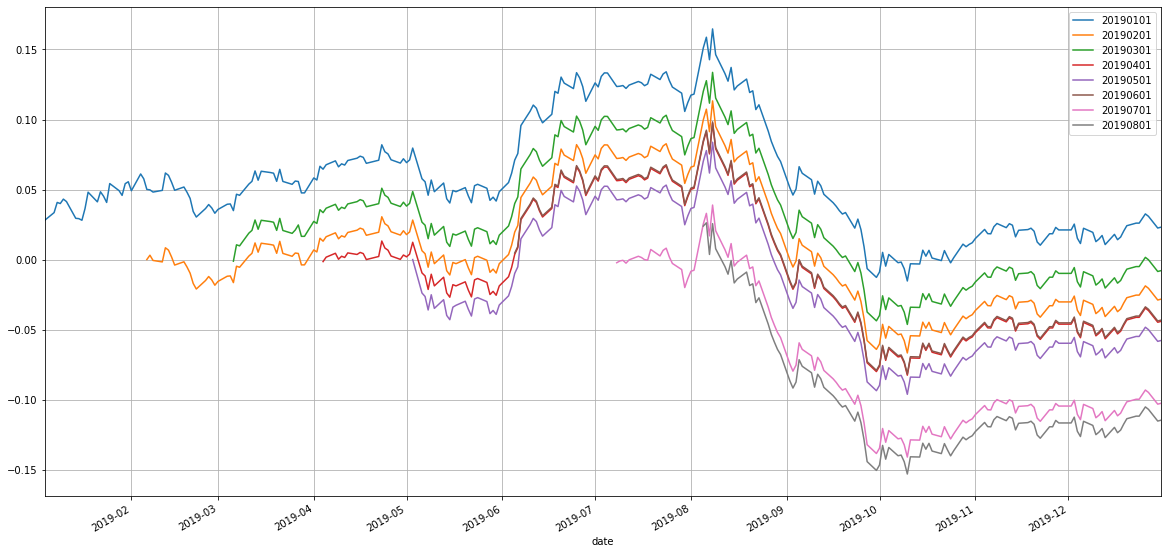

In [11]:
np.log(returns+1).cumsum().plot(figsize=(20,10), grid=True);

In [12]:
returns = pd.DataFrame()
for k, v in d.items():
    returns[k] = v.returns[0]
returns

,20190101,20190201,20190301,20190401,20190501,20190601,20190701,20190801
date,,,,,,,,
2019-01-04,0.028495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,0.005435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,0.007286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,-0.000781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-10,0.003156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607,0.006607
2019-12-27,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719,-0.001719


In [13]:
pnls = {}
for k, v in d.items():
    pnls[k] = v.dfs[0].loc['20190801': '20190831'].pnl.sum()
pnls

{'20190101': -304.25,
 '20190201': -304.25,
 '20190301': -304.25,
 '20190401': -304.25,
 '20190501': -304.25,
 '20190601': -304.25,
 '20190701': -304.25,
 '20190801': -503.375}

In [14]:
dfs = {}
for k, v in d.items():
    dfs[k] = v.dfs[0].loc['20190801': '20190831']

In [15]:
dfs['20190301']

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl
date,,,,,,,,,
2019-08-01 00:18:00,7850.00,-1.0,-1,-1,0,0.000,-7850.00,-7854.75,4.750
2019-08-01 02:12:00,7829.50,-1.0,-1,-1,0,0.000,-7829.50,-7850.00,20.500
2019-08-01 03:38:00,7831.25,-1.0,-1,-1,0,0.000,-7831.25,-7829.50,-1.750
2019-08-01 05:28:00,7865.00,-1.0,-1,-1,0,0.000,-7865.00,-7831.25,-33.750
2019-08-01 08:33:00,7873.75,-1.0,-1,-1,0,0.000,-7873.75,-7865.00,-8.750
...,...,...,...,...,...,...,...,...,...
2019-08-30 21:29:00,7662.25,0.0,0,0,0,0.000,0.00,0.00,0.000
2019-08-30 21:45:00,7674.50,1.0,1,0,0,0.000,0.00,0.00,0.000
2019-08-30 21:55:00,7677.75,1.0,1,1,1,0.375,0.00,0.00,-0.375


In [16]:
dfs['20190701']

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl
date,,,,,,,,,
2019-08-01 00:18:00,7850.00,-1.0,-1,-1,0,0.000,-7850.00,-7854.75,4.750
2019-08-01 02:12:00,7829.50,-1.0,-1,-1,0,0.000,-7829.50,-7850.00,20.500
2019-08-01 03:38:00,7831.25,-1.0,-1,-1,0,0.000,-7831.25,-7829.50,-1.750
2019-08-01 05:28:00,7865.00,-1.0,-1,-1,0,0.000,-7865.00,-7831.25,-33.750
2019-08-01 08:33:00,7873.75,-1.0,-1,-1,0,0.000,-7873.75,-7865.00,-8.750
...,...,...,...,...,...,...,...,...,...
2019-08-30 21:29:00,7662.25,0.0,0,0,0,0.000,0.00,0.00,0.000
2019-08-30 21:45:00,7674.50,1.0,1,0,0,0.000,0.00,0.00,0.000
2019-08-30 21:55:00,7677.75,1.0,1,1,1,0.375,0.00,0.00,-0.375


In [27]:
dfs['20190701'].loc['2019-08-05 04:26:00':].head(20)

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl
date,,,,,,,,,
2019-08-05 04:26:00,7620.00,-1.0,-1,-1,0,0.0,-7620.00,-7616.50,-3.50
2019-08-05 04:46:00,7604.25,-1.0,-1,-1,0,0.0,-7604.25,-7620.00,15.75
2019-08-05 05:28:00,7605.50,-1.0,-1,-1,0,0.0,-7605.50,-7604.25,-1.25
2019-08-05 07:01:00,7578.00,-1.0,-1,-1,0,0.0,-7578.00,-7605.50,27.50
2019-08-05 08:16:00,7590.75,-1.0,-1,-1,0,0.0,-7590.75,-7578.00,-12.75
2019-08-05 09:19:00,7607.00,-1.0,-1,-1,0,0.0,-7607.00,-7590.75,-16.25
2019-08-05 10:07:00,7607.25,-1.0,-1,-1,0,0.0,-7607.25,-7607.00,-0.25
2019-08-05 10:50:00,7575.25,-1.0,-1,-1,0,0.0,-7575.25,-7607.25,32.00
2019-08-05 11:28:00,7574.75,-1.0,-1,-1,0,0.0,-7574.75,-7575.25,0.50


In [29]:
dfs['20190701'].loc['2019-08-05 04:26:00':'20190831'].pnl.sum()

-412.75

In [28]:
dfs['20190801'].head(20)

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl
date,,,,,,,,,
2019-08-05 04:26:00,7620.00,-1.0,-1,0,0,0.000,0.00,0.00,0.000
2019-08-05 04:46:00,7604.25,-1.0,-1,-1,-1,0.375,0.00,0.00,-0.375
2019-08-05 05:28:00,7605.50,-1.0,-1,-1,0,0.000,-7605.50,-7604.25,-1.250
2019-08-05 07:01:00,7578.00,-1.0,-1,-1,0,0.000,-7578.00,-7605.50,27.500
2019-08-05 08:16:00,7590.75,-1.0,-1,-1,0,0.000,-7590.75,-7578.00,-12.750
2019-08-05 09:19:00,7607.00,-1.0,-1,-1,0,0.000,-7607.00,-7590.75,-16.250
2019-08-05 10:07:00,7607.25,-1.0,-1,-1,0,0.000,-7607.25,-7607.00,-0.250
2019-08-05 10:50:00,7575.25,-1.0,-1,-1,0,0.000,-7575.25,-7607.25,32.000
2019-08-05 11:28:00,7574.75,-1.0,-1,-1,0,0.000,-7574.75,-7575.25,0.500


In [19]:
test = d['20190801'].dfs[0].loc['20190801': '20190831']

In [20]:
test.sort_values('pnl').head(50)

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl
date,,,,,,,,,
2019-08-15 13:43:00,7507.50,0.0,0,0,1,0.375,-7507.50,-7451.25,-56.625
2019-08-09 00:31:00,7680.25,0.0,0,0,-1,0.375,7680.25,7733.50,-53.625
2019-08-23 17:03:00,7649.25,-1.0,-1,-1,-2,0.750,7649.25,7699.00,-50.500
2019-08-13 15:38:00,7604.50,0.0,0,0,1,0.375,-7604.50,-7557.00,-47.875
2019-08-29 16:42:00,7660.25,0.0,0,0,-1,0.375,7660.25,7707.25,-47.375
2019-08-06 03:15:00,7324.75,-1.0,-1,-1,0,0.000,-7324.75,-7279.75,-45.000
2019-08-23 14:05:00,7694.25,0.0,0,0,-1,0.375,7694.25,7738.50,-44.625
2019-08-07 14:16:00,7498.25,1.0,1,1,0,0.000,7498.25,7540.50,-42.250
2019-08-06 02:45:00,7274.25,-1.0,-1,-1,0,0.000,-7274.25,-7236.50,-37.750


In [21]:
may = d['20180501'].positions[0].tail(50)

KeyError: '20180501'

In [ ]:
june = d['20180601'].positions[0].tail(50)

In [ ]:
may.pnl.sum(), june.pnl.sum()

In [ ]:
may.sort_values('pnl')

In [ ]:
june.sort_values('pnl')

In [ ]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
from datastore import Store

In [ ]:
store = Store()

In [ ]:
store.read('/cont/min/NQ_20200320_GLOBEX_USD').sort_index()